In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_excel('limas.xlsx')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

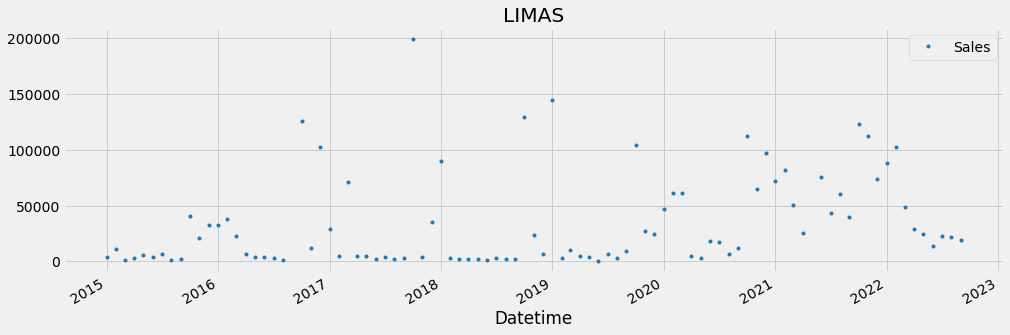

In [3]:
df.plot(style=".", 
        figsize=(15,5), 
        color=color_pal[0], 
        title="LIMAS")
plt.show()

In [4]:
df.head()

,Sales
Datetime,
2015-01-01,4173
2015-02-01,10667
2015-03-01,797
2015-04-01,2808
2015-05-01,5886


Outlier Analysis and removal

<AxesSubplot:ylabel='Frequency'>

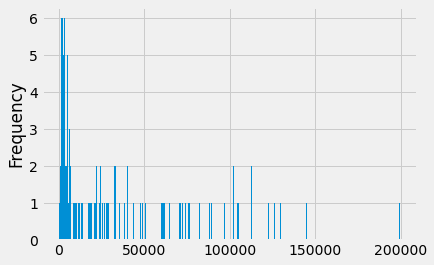

In [5]:
df['Sales'].plot(kind='hist', bins=300)

<AxesSubplot:xlabel='Datetime'>

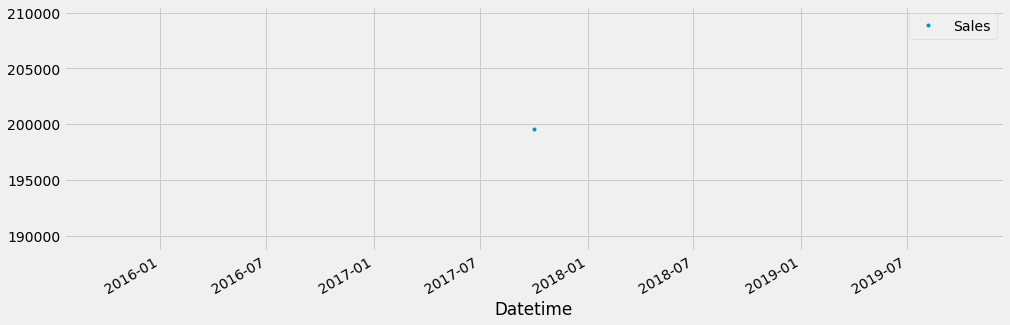

In [6]:
df.query('Sales > 150_000').plot(figsize=(15,5), style='.')

In [7]:
df = df.query('Sales < 150_000').copy()

Time Series Cross Validation

In [8]:
from sklearn.model_selection import TimeSeriesSplit

In [9]:
tss = TimeSeriesSplit(n_splits=5, test_size=10)
df = df.sort_index()

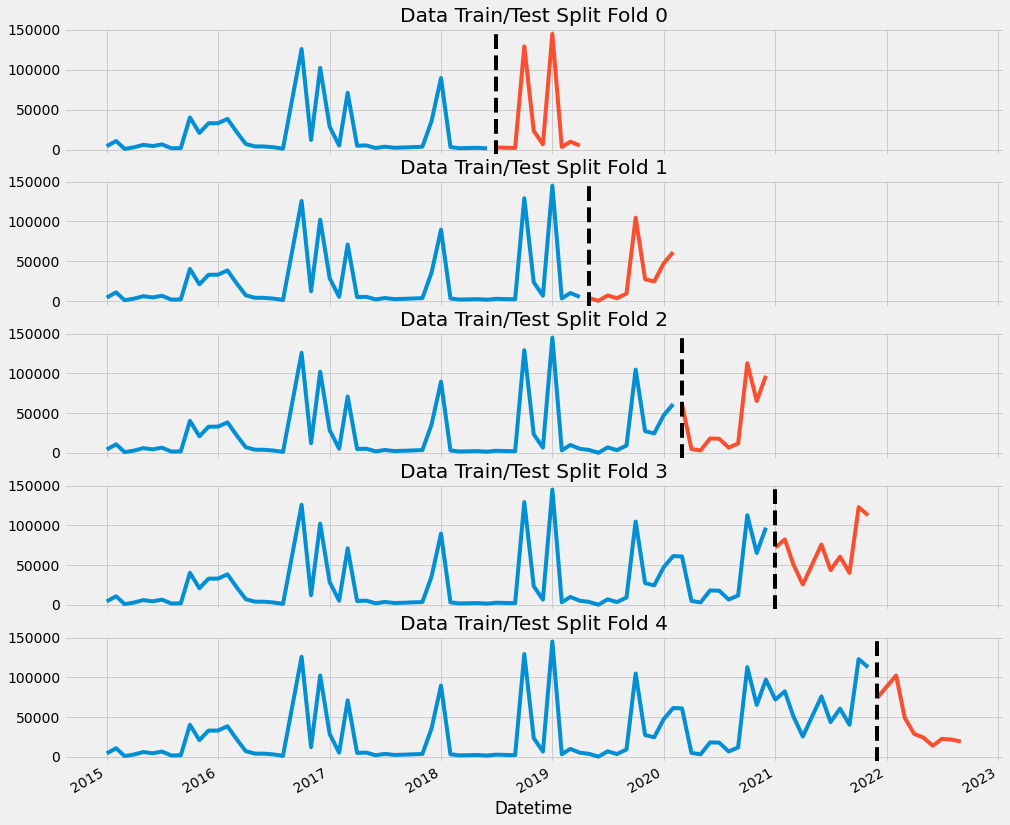

In [10]:
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Sales'].plot(ax=axs[fold],
                       label='Training Set',
                       title=f'Data Train/Test Split Fold {fold}')
    test['Sales'].plot(ax=axs[fold],
                      label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

Forecasting Horizon

In [11]:
def create_features(df):
    #create time series fatures based on time series index
    df= df.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    return df

df = create_features(df)

Lag Features

In [12]:
df

,Sales,quarter,month,year,dayofyear,dayofmonth
Datetime,,,,,,
2015-01-01,4173,1,1,2015,1,1
2015-02-01,10667,1,2,2015,32,1
2015-03-01,797,1,3,2015,60,1
2015-04-01,2808,2,4,2015,91,1
2015-05-01,5886,2,5,2015,121,1
...,...,...,...,...,...,...
2022-05-01,24153,2,5,2022,121,1
2022-06-01,13789,2,6,2022,152,1
2022-07-01,22490,3,7,2022,182,1


In [13]:
def add_lags(df):
    target_map = df['Sales'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('15 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('60 days')).map(target_map)
    return df

In [14]:
df = add_lags(df)

In [15]:
df.head()

,Sales,quarter,month,year,dayofyear,dayofmonth,lag1,lag2,lag3
Datetime,,,,,,,,,
2015-01-01,4173,1,1,2015,1,1,NaN,NaN,NaN
2015-02-01,10667,1,2,2015,32,1,NaN,NaN,NaN
2015-03-01,797,1,3,2015,60,1,NaN,NaN,NaN
2015-04-01,2808,2,4,2015,91,1,NaN,NaN,NaN
2015-05-01,5886,2,5,2015,121,1,NaN,2808.0,NaN


In [16]:
df.tail()

,Sales,quarter,month,year,dayofyear,dayofmonth,lag1,lag2,lag3
Datetime,,,,,,,,,
2022-05-01,24153,2,5,2022,121,1,NaN,28726.0,NaN
2022-06-01,13789,2,6,2022,152,1,NaN,NaN,NaN
2022-07-01,22490,3,7,2022,182,1,NaN,13789.0,NaN
2022-08-01,21581,3,8,2022,213,1,NaN,NaN,NaN
2022-09-01,19140,3,9,2022,244,1,NaN,NaN,NaN


In [17]:
#print(df.to_string())

In [18]:
tss = TimeSeriesSplit(n_splits=5, test_size=10)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train = create_features(train)
    test = create_features(test)

FEATURES = ['quarter', 'month', 'year', 
            'dayofyear', 'dayofmonth', 
            'lag1', 'lag2', 'lag3']
TARGET = 'Sales'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                      n_estimators=1000,
                      eaerly_stopping_rounds=50,
                      objective='reg:linear',
                      max_depth=3,
                      learning_rate=0.01)
reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=100)

y_pred = reg.predict(X_test)
preds.append(y_pred)
score = np.sqrt(mean_squared_error(y_test, y_pred))
scores.append(score)

[17:23:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[17:23:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "eaerly_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:48636.05831	validation_1-rmse:53514.03523
[100]	validation_0-rmse:26658.06663	validation_1-rmse:29993.20210
[200]	validation_0-rmse:18643.75546	validation_1-rmse:25195.73669
[300]	validation_0-rmse:15712.78868	validation_1-rmse:25685.05208
[400]	validation_0-rmse:14582.23616	validation_1-rmse:

In [19]:
scores

[28939.500397562064]